In [1]:
#Import required packages
! pip install pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pylab import rcParams
import matplotlib as mpl
import statsmodels.api as sm
from pyspark.sql.window import Window

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 30.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d427d019b10a20a40e037d01d4fd350fabab92df8fd9c72a226b422b062290f1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Spark Session is created
EXECUTOR_MEMORY = "4g"
DRIVER_MEMORY = "8g"
EXECUTOR_CORES = "4"

spark = SparkSession \
    .builder \
    .appName("PhiladelphiaCrime") \
    .config("spark.executor.memory", EXECUTOR_MEMORY) \
    .config("spark.driver.memory", DRIVER_MEMORY) \
    .config("spark.executor.cores", EXECUTOR_CORES) \
    .getOrCreate()

In [8]:
crime_data = "/content/crime_incidents.csv"

file_schema = StructType([StructField('ObjectID', IntegerType(), True),
                     StructField('DCDist', IntegerType(), True),
                     StructField('PSA', StringType(), True),
                     StructField('DispatchDateTime', StringType(), True),
                     StructField('DispatchDate', StringType(), True),
                     StructField('DispatchTime', StringType(), True),
                     StructField('DispatchHour', StringType(), True),
                     StructField('DCKey', StringType(), True),
                     StructField('LocationBlock', StringType(), True),
                     StructField('UCRGeneral', IntegerType(), True),
                     StructField('TextGeneralCode', StringType(), True),
                     StructField('Point_X', FloatType(), True),
                     StructField('Point_Y', FloatType(), True),
                     StructField('Latitude', FloatType(), True),
                     StructField('Longitude', FloatType(), True)])

crime_df = spark.read.csv(crime_data, header=True, schema=file_schema)

In [9]:
weather_data = "/content/weather_data.csv"

weather_schema = StructType([StructField('DateTime', StringType(), True),
                             StructField('MaxTemperature', IntegerType(), True),
                             StructField('MinTemperature', IntegerType(), True),
                             StructField('Snow', FloatType(), True),
                             StructField('CloudCover', IntegerType(), True),
                             StructField('Precipitation', FloatType(), True)])

weather_df = spark.read.csv(weather_data, header=True, schema=weather_schema)

In [14]:
# Format the date and timestamp column 
crime_df1 = (crime_df
              .withColumn("DispatchDateAndTime", to_timestamp(col("DispatchDateTime"), "yyyy-MM-dd HH:mm:ss"))
              .withColumn("DispatchMonth", month(to_timestamp(col("DispatchDateTime"), "yyyy-MM-dd HH:mm:ss")))
              .withColumn("DispatchMonthName", date_format(to_timestamp(col("DispatchDateTime"), "yyyy-MM-dd HH:mm:ss"),'MMM'))
              .withColumn("DispatchYear", year(to_timestamp(col("DispatchDateTime"), "yyyy-MM-dd HH:mm:ss")))
              .withColumn("DispatchDate", to_date(col("DispatchDate"), "yyyy-MM-dd"))
              .withColumn("DispatchHour",hour(to_timestamp(col("DispatchDateTime"), "yyyy-MM-dd HH:mm:ss")))
              .withColumn('DispatchDay', date_format(col("DispatchDateTime"), "EEEE"))
              .withColumn('DispatchDayNumber', (dayofweek(col("DispatchDateTime"))))
              .withColumn("DCKey",col("DCKey").cast(LongType()))
              .withColumn("CrimeType", when(col('UCRGeneral') < 800, "Voilent").otherwise("Non-Voilent"))
              .withColumn("CrimeDescription", when(col('UCRGeneral') == 100, "Homicide").when(col('UCRGeneral') == 300, "Robbery")
                          .when(col('UCRGeneral') == 400, "Aggravated Assault")
                          .when(col('UCRGeneral') == 500, "Burglary")
                          .when(col('UCRGeneral') == 600, "Theft")
                          .when(col('UCRGeneral') == 700, "Motor Vehicle Theft").otherwise(col("TextGeneralCode")))
              .withColumn("EndPos", when(instr('LocationBlock',' ST')!=0, instr('LocationBlock',' ST')+3)
                          .when(instr('LocationBlock',' RD')!=0,instr('LocationBlock',' RD')+3)
                          .when(instr('LocationBlock',' AVE')!=0,instr('LocationBlock',' AVE')+4)
                          .when(instr('LocationBlock',' AV')!=0,instr('LocationBlock',' AV')+3)
                          .when(instr('LocationBlock',' WAY')!=0,instr('LocationBlock',' WAY')+4)
                          .when(instr('LocationBlock',' BLVD')!=0,instr('LocationBlock',' BLVD')+5)
                          .when(instr('LocationBlock',' LN')!=0,instr('LocationBlock',' LN')+3)
                          .when(instr('LocationBlock',' LA')!=0,instr('LocationBlock',' LA')+3)
                          .when(instr('LocationBlock',' DR')!=0,instr('LocationBlock',' DR')+3)
                          .otherwise(length('LocationBlock')))
                .withColumn("StartPos", when(instr('LocationBlock','BLOCK')!=0, instr('LocationBlock','BLOCK') + 6)
                          .otherwise(0))
                .withColumn("StreetVal", expr("""substring(LocationBlock,StartPos,EndPos - StartPos)"""))
                .withColumn("Street", when((expr("""length(StreetVal)< 2 """)),col('LocationBlock')).otherwise(col('StreetVal')))
                .drop("Point_X")
                .drop("Point_Y")
                .drop("EndPos")
                .drop("StartPos")
                .drop("DispatchDateTime")
                .drop("StreetVal")
               )

In [15]:
crime_df1.cache()
print("Number of rows: ", crime_df1.count())
print("Null values in DCDist: ", crime_df1.where(crime_df1["DCDist"].isNull()).count())
print("Null values in DispatchDate: ", crime_df1.where(crime_df1["DispatchDate"].isNull()).count())
print("Null values in DispatchHour: ", crime_df1.where(crime_df1["DispatchHour"].isNull()).count())
print("Null values in UCRGeneral: ", crime_df1.where(crime_df1["UCRGeneral"].isNull()).count())
print("Null values in TextGeneralCode: ", crime_df1.where(crime_df1["TextGeneralCode"].isNull()).count())
print("Null values in LocationBlock: ", crime_df1.where(crime_df1["LocationBlock"].isNull()).count())
print("Null values in Latitude: ", crime_df1.where(crime_df1["Latitude"].isNull()).count())
print("Null values in Longitude: ", crime_df1.where(crime_df1["Longitude"].isNull()).count())
print("Null values in PSA: ", crime_df1.where(crime_df1["PSA"].isNull()).count())

Number of rows:  1721420
Null values in DCDist:  0
Null values in DispatchDate:  0
Null values in DispatchHour:  0
Null values in UCRGeneral:  0
Null values in TextGeneralCode:  0
Null values in LocationBlock:  0
Null values in Latitude:  0
Null values in Longitude:  0
Null values in PSA:  470


In [16]:
crime_df_dropnull = (crime_df1.dropna()
                     .where(col("DispatchDate")<=to_date(lit("2021-06-30"),"yyyy-MM-dd"))
                    )


In [ ]:
crime_df2 = crime_df_dropnull.dropDuplicates()

In [ ]:
weather_df2 = (weather_df
                  .withColumn("YearPart", split(col("DateTime"),'/')[2])
                  .withColumn("TimePart", split(col("YearPart"),' ')[1])
                  .withColumn("Year", split(col("YearPart"),' ')[0])
                  .withColumn("Day", split(col("DateTime"),'/')[1])
                  .withColumn("Month", split(col("DateTime"),'/')[0])
                  .withColumn("MonthVal", when(length("Month")==1, concat(lit("0"),col("Month")))
                              .otherwise(col("Month")))
                  .withColumn("DayVal", when(length("Day")==1, concat(lit("0"),col("Day")))
                              .otherwise(col("Day")))
                  .withColumn("DatePart", concat_ws('-',col("Year"),col("MonthVal"),col("DayVal")))
                  .withColumn("Date", to_date(col("DatePart"),"yyyy-MM-dd"))
                  .withColumn("Hour", split(col("TimePart"),':')[0])
                  .drop("YearPart")
                  .drop("TimePart")
                  .drop("Year")
                  .drop("Day")
                  .drop("DayVal")
                  .drop("Month")
                  .drop("MonthVal")
                  .drop("DateTime")
                  .drop("DatePart")
                 )

In [ ]:
crime_df3 = (crime_df2
              .where(col("Latitude") >= 39.87502))

In [ ]:
# Join Crime and weather dataset based on date and hour, The weather data that we are using is hourly dataset
crime_df_join = crime_df1.join(weather_df2, ((crime_df3['DispatchDate'] == weather_df2['Date']) & (crime_df3['DispatchHour'] == weather_df2['Hour']))).drop("Date").drop("Hour")

# Partition the dataset based on Year
crime_df_join.repartition("DispatchYear")

# We will be using this dataset very frequently in further part of the notebook, caching this dataframe
crime_df_join.cache()

DataFrame[ObjectID: int, DCDist: int, PSA: string, DispatchDate: date, DispatchTime: string, DispatchHour: int, DCKey: bigint, LocationBlock: string, UCRGeneral: int, TextGeneralCode: string, Latitude: float, Longitude: float, DispatchDateAndTime: timestamp, DispatchMonth: int, DispatchMonthName: string, DispatchYear: int, DispatchDay: string, DispatchDayNumber: int, CrimeType: string, CrimeDescription: string, Street: string, MaxTemperature: int, MinTemperature: int, Snow: float, CloudCover: int, Precipitation: float]

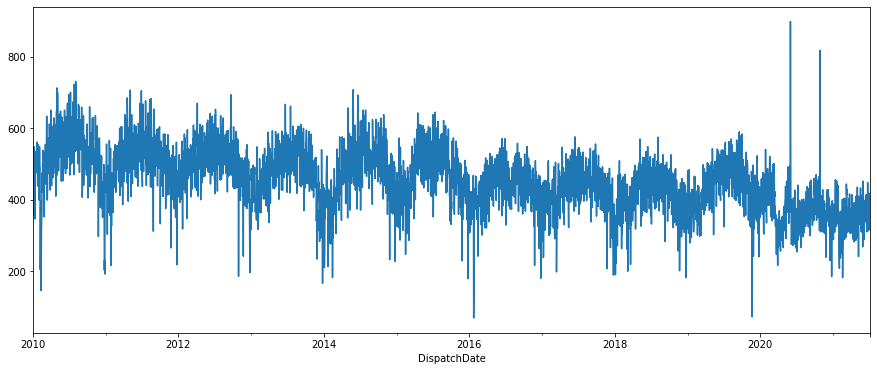

In [ ]:
#  Highest number of crimes in year and date
crime_count = (crime_df_join
                    .select("DispatchDate")
                    .groupBy("DispatchDate")
                    .count()
                    .orderBy("DispatchDate", ascending=True)).toPandas()

crime_count['DispatchDate']= pd.to_datetime(crime_count['DispatchDate'])
crime_count = crime_count.set_index('DispatchDate')

fig, ax = plt.subplots(nrows=1, ncols=1)

crime_count.plot(figsize=(15, 6),ax=ax,legend=False)

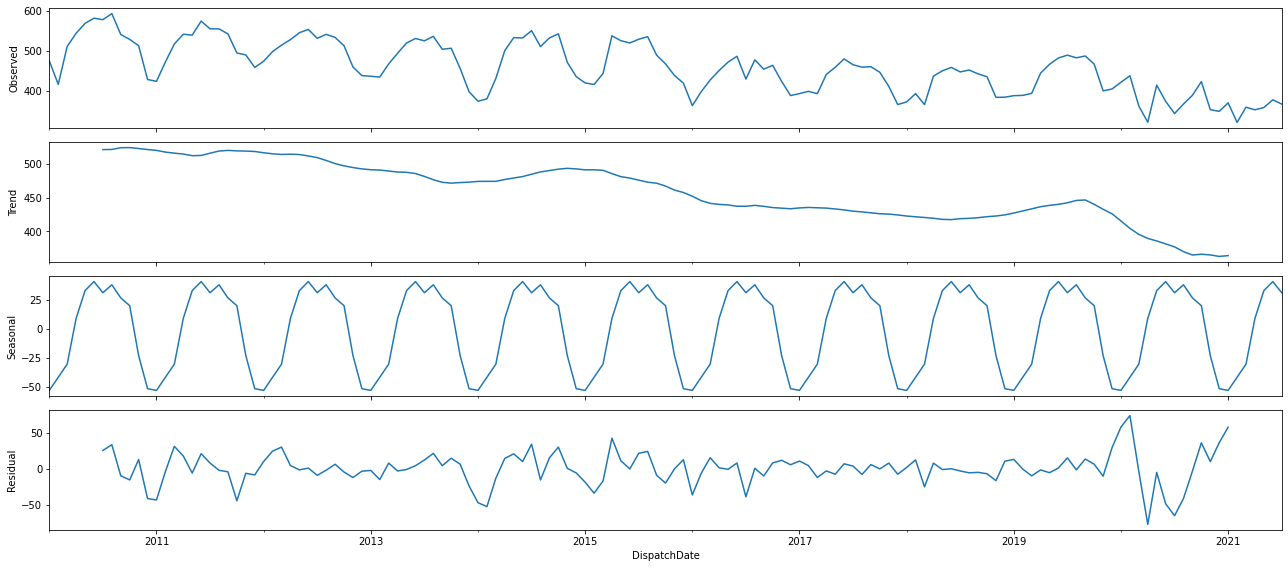

In [ ]:

y = crime_count['count'].resample('MS').mean()
rcParams['figure.figsize'] = 10, 5

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

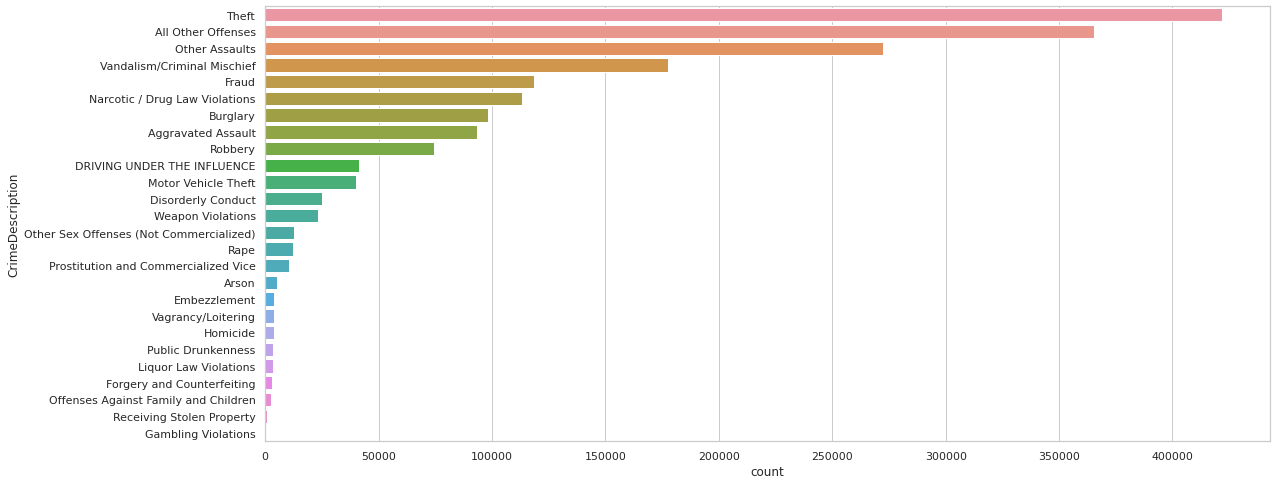

In [ ]:
crime_count_map = (crime_df_join.groupBy('CrimeDescription').count().orderBy('count', ascending=False)).toPandas()

sb.set(font_scale=1, style = "whitegrid")
sb.barplot(x= "count", y = "CrimeDescription", data = crime_count_map)

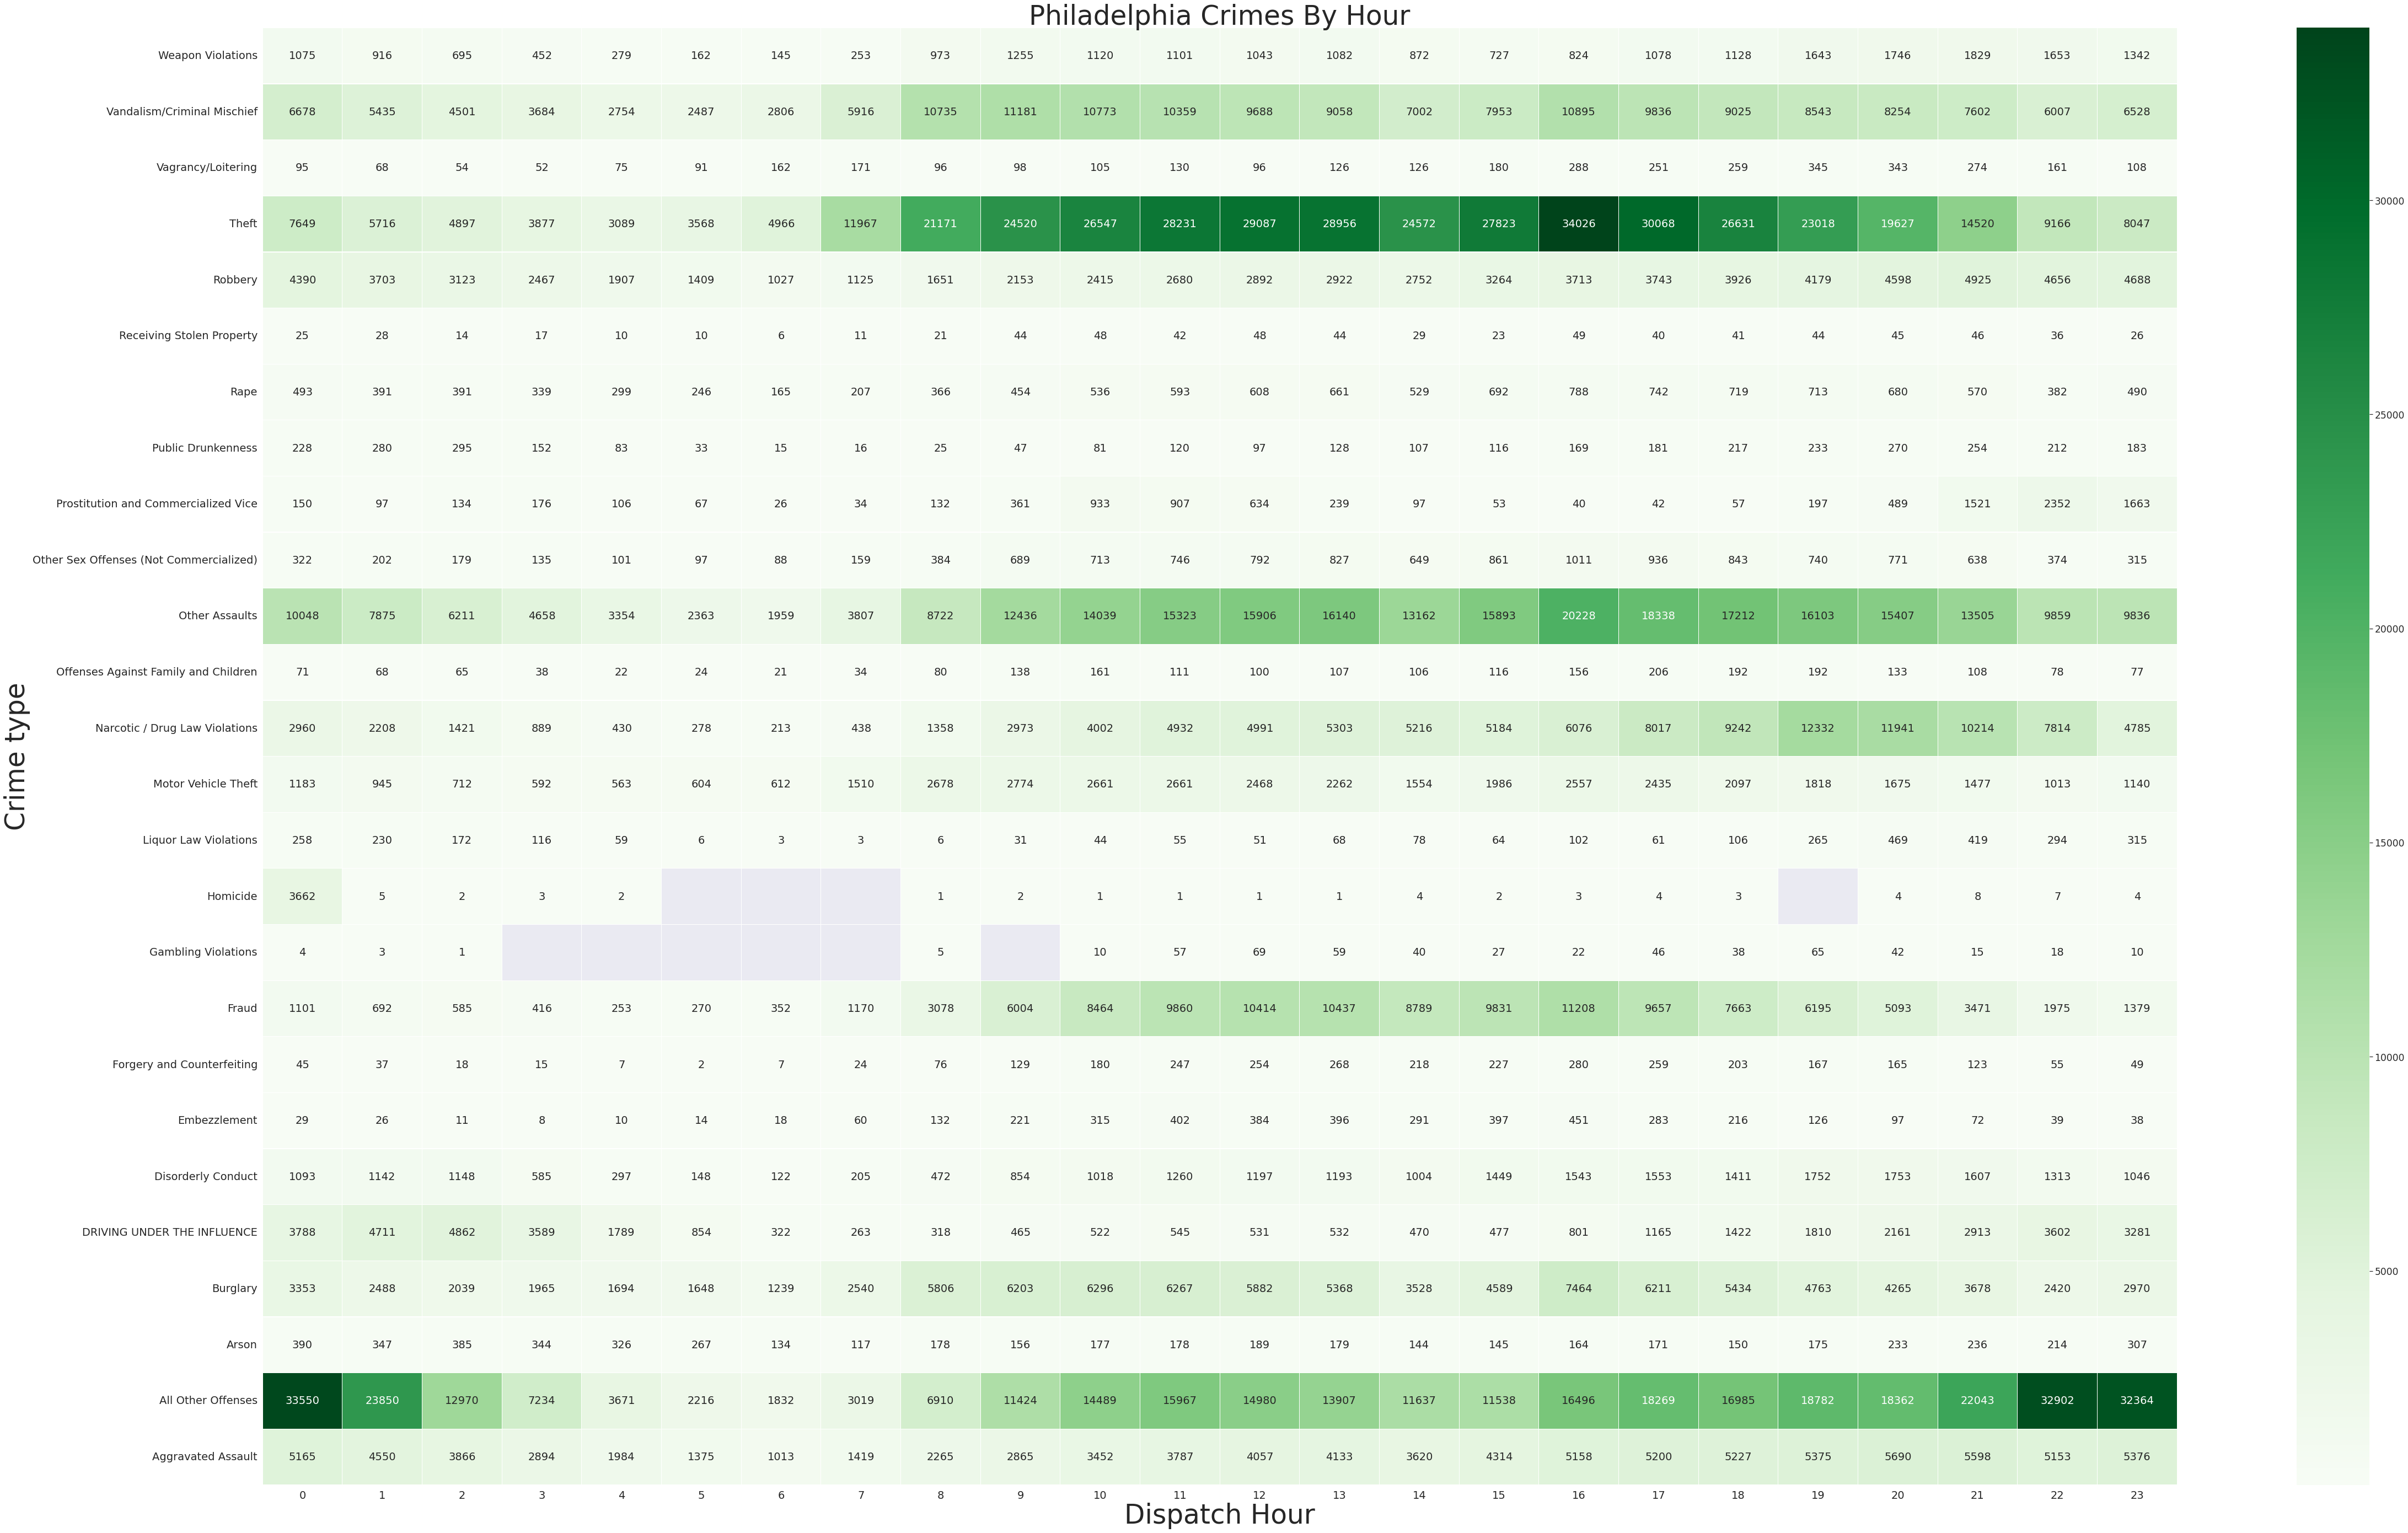

In [ ]:
# Heat map between dispach hour and crime type

crime_count_hour = (crime_df_join.groupBy('CrimeDescription','DispatchHour').count().orderBy('count', ascending=False)).toPandas()
crime_count_hour_pt = crime_count_hour.pivot('CrimeDescription','DispatchHour','count')

fig = plt.figure(num=None, figsize=(80, 50), dpi=70)
sb.set(font_scale=1.6)

res = sb.heatmap(data=crime_count_hour_pt, annot=True, fmt="g", linewidths=.2, cmap="Greens",  annot_kws={"size": 20})
res.invert_yaxis()

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 20, rotation=360)


plt.title("Philadelphia Crimes By Hour",size=50)
plt.xlabel("Dispatch Hour",size=50)
plt.ylabel("Crime type",size=50)
plt.show()

In [ ]:
# Highest number of crime wrt year
(crime_df_join
 .select("DispatchYear")
 .groupBy("DispatchYear")
 .count()
 .orderBy("count", ascending=False)
 .show(n=10, truncate=False))

+------------+------+
|DispatchYear|count |
+------------+------+
|2010        |191247|
|2011        |187552|
|2012        |186990|
|2013        |176790|
|2014        |176442|
|2015        |174723|
|2019        |161087|
|2016        |159606|
|2017        |157314|
|2018        |152700|
+------------+------+
only showing top 10 rows



In [ ]:
display(crime_df_join
        .select("CrimeDescription")
        .where((col("MinTemperature") < 0) & (col("Snow") != 0) & (col("CloudCover") > 0) & (col("CloudCover") < 100) & (col("Precipitation") > 0))
        .groupBy("CrimeDescription")
        .count()
        .orderBy("count", ascending=False))

DataFrame[CrimeDescription: string, count: bigint]